In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import re

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
subm = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


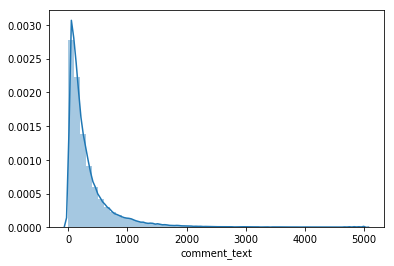

In [4]:
len_tr=train.comment_text.str.len()
sns.distplot(len_tr)

In [5]:
labeled_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[labeled_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
none             0
dtype: int64

In [7]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [9]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

In [10]:
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [11]:
X = train.comment_text
test_X = test.comment_text

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
X_dtm = vect.fit_transform(X)
test_X_dtm = vect.transform(test_X)

In [13]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('../input/sample_submission.csv')

for label in labeled_cols:
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy is 0.9639846839337975
... Processing severe_toxic
Training accuracy is 0.9920912947841399
... Processing obscene
Training accuracy is 0.9832363023356374
... Processing threat
Training accuracy is 0.9981199591404453
... Processing insult
Training accuracy is 0.9755469352200588
... Processing identity_hate
Training accuracy is 0.9939713356436947


In [14]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999956,0.463340,0.999965,0.050225,0.971126,0.431323
1,0000247867823ef7,0.002395,0.000432,0.000401,0.000329,0.003284,0.000396
2,00013b17ad220c46,0.011101,0.000119,0.003185,0.000035,0.007277,0.001253
3,00017563c3f7919a,0.001327,0.002132,0.000965,0.000117,0.000872,0.000033
4,00017695ad8997eb,0.019301,0.000835,0.001252,0.000607,0.003282,0.000567


In [15]:
submission_binary.to_csv('submission_binary.csv',index=False)

In [16]:
# create submission file
submission_chains = pd.read_csv('../input/sample_submission.csv')
# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [17]:
for label in labeled_cols:
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy is 0.9639846839337975
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing severe_toxic
Training Accuracy is 0.9926239730276805
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing obscene
Training Accuracy is 0.9852980804782824
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing threat
Training Accuracy is 0.9984395660865696
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing insult
Training Accuracy is 0.9826973572892318
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing identity_hate
Training Accuracy is 0.9956069711915072
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


In [18]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999956,0.435189,0.999693,0.081654,0.858657,0.552357
1,0000247867823ef7,0.002395,0.000004,0.000228,0.000082,0.003221,0.000126
2,00013b17ad220c46,0.011101,0.000001,0.000981,0.000013,0.002519,0.000564
3,00017563c3f7919a,0.001327,0.000062,0.001102,0.000065,0.000422,0.000006
4,00017695ad8997eb,0.019301,0.000005,0.000321,0.000169,0.000844,0.000101


In [19]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

In [20]:
# create submission file
submission_combined = pd.read_csv('../input/sample_submission.csv')

In [21]:
for label in labeled_cols:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [22]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999956,0.449265,0.999829,0.065939,0.914891,0.491840
1,0000247867823ef7,0.002395,0.000218,0.000315,0.000206,0.003252,0.000261
2,00013b17ad220c46,0.011101,0.000060,0.002083,0.000024,0.004898,0.000908
3,00017563c3f7919a,0.001327,0.001097,0.001034,0.000091,0.000647,0.000020
4,00017695ad8997eb,0.019301,0.000420,0.000787,0.000388,0.002063,0.000334


In [23]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)

<a href="./submission_combined.csv"> Download File </a>